In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install python-louvain


Loaded Louvain partition from saved file.
Louvain detected 35 communities in the network.
Loaded graph positions from saved file.


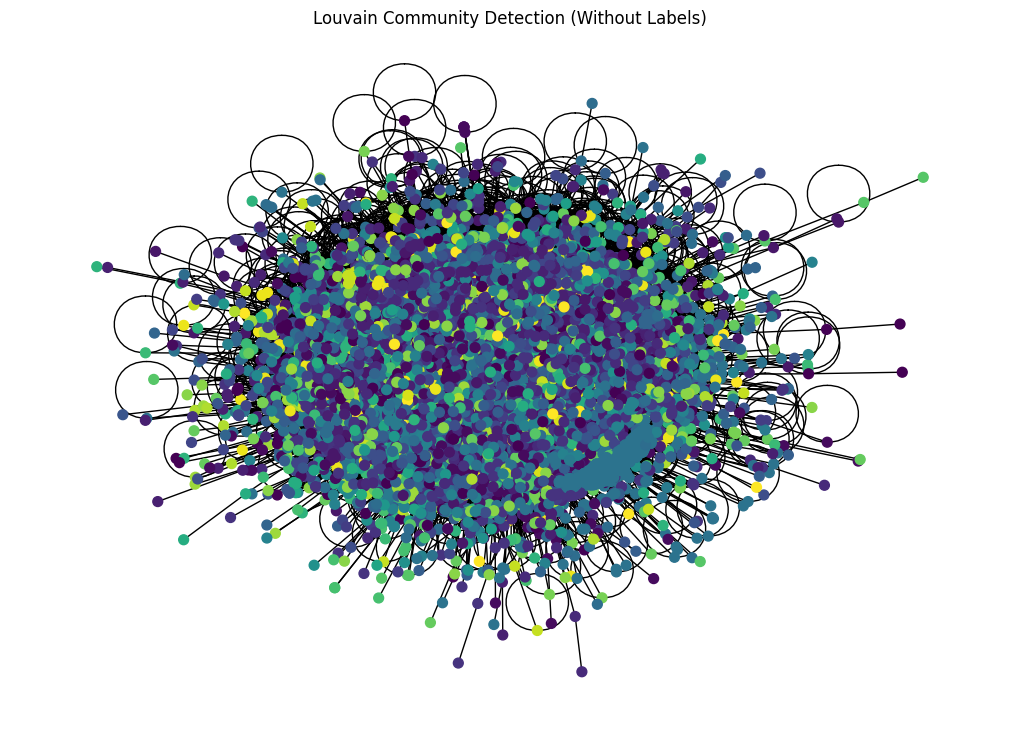

In [3]:
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import pickle  # For saving Python objects

# Load edgelist
file_path = '/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/edgelist_2022.csv'
edges = pd.read_csv(file_path)

# Create graph using only the edgelist
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract the largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Apply Louvain community detection (Check if saved data exists)
partition_file = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/louvain_partition.pkl"

try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("Louvain partition computed and saved.")

# Count number of detected communities
num_communities = len(set(partition.values()))
print(f"Louvain detected {num_communities} communities in the network.")

# Assign community to nodes
nx.set_node_attributes(G, partition, 'community')

# Save Graph positions for consistency in visualization
pos_file = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/graph_positions.pkl"

try:
    with open(pos_file, "rb") as f:
        pos = pickle.load(f)
    print("Loaded graph positions from saved file.")
except FileNotFoundError:
    pos = nx.spring_layout(G)  # Compute if not saved
    with open(pos_file, "wb") as f:
        pickle.dump(pos, f)
    print("Graph positions computed and saved.")

# Visualize the network with communities
cmap = plt.get_cmap('viridis')
colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_color=colors, node_size=50, cmap=cmap, with_labels=False)
plt.title("Louvain Community Detection (Without Labels)")
plt.show()




plot community as nodes

Loaded Louvain partition from saved file.


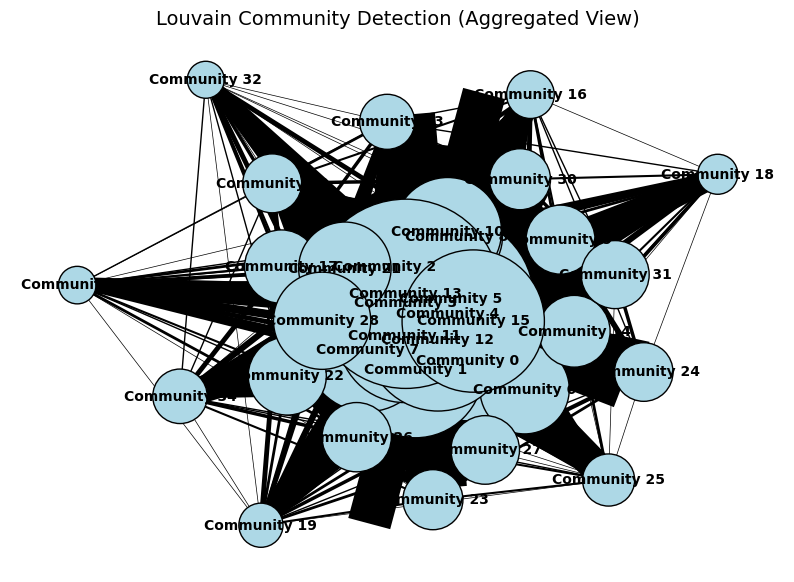

In [ ]:
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import pickle

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"

# Load edgelist
edges = pd.read_csv(edgelist_file)

# Create graph from edgelist
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract the largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Apply Louvain OR load from saved file
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("Louvain partition computed and saved.")

# Create a mapping of nodes to communities
community_nodes = {}
for node, comm in partition.items():
    if comm not in community_nodes:
        community_nodes[comm] = []
    community_nodes[comm].append(node)

# Create a community-level graph (meta-graph)
C = nx.Graph()

# Add nodes (communities) with size based on population
for comm, nodes in community_nodes.items():
    C.add_node(comm, size=len(nodes))  # Node size = number of users in the community

# Add edges between communities based on inter-community connections
for u, v in G.edges():
    comm_u, comm_v = partition[u], partition[v]
    if comm_u != comm_v:  # Only count inter-community edges
        if C.has_edge(comm_u, comm_v):
            C[comm_u][comm_v]['weight'] += 1
        else:
            C.add_edge(comm_u, comm_v, weight=1)

# Generate positions for the community graph
pos = nx.spring_layout(C, seed=42)  # Layout for readability

# Extract sizes for node scaling
node_sizes = [C.nodes[comm]['size'] * 10 for comm in C.nodes()]  # Scale sizes

# Draw the simplified community graph
plt.figure(figsize=(10, 7))
nx.draw_networkx_edges(C, pos, width=[C[u][v]['weight'] * 0.5 for u, v in C.edges()])  # Edge thickness = link weight
nx.draw_networkx_nodes(C, pos, node_size=node_sizes, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(C, pos, labels={comm: f"Community {comm}" for comm in C.nodes()}, font_size=10, font_weight="bold")

# Finalize plot
plt.title("Louvain Community Detection (Aggregated View)", fontsize=14)
plt.axis("off")
plt.show()




Loaded Louvain partition from saved file.
Louvain detected 35 communities in the network.
Community Composition:
label      0.0   1.0  African  American  Argentine  Asian  Australian  \
community                                                               
0          174   586        1       363          0      1           1   
1          190   765        1       501          1      1           0   
2           88   399        3       249          0      1           2   
3          202  1105        0       674          1      2           4   
4          290  1180        4       767          0      2           0   
5          215  1209        1       734          0      1           0   
6           79   335        2       225          0      0           0   
7          152   642        2       421          0      4           1   
8           92   349        0       238          0      1           2   
9           48   199        1       138          0      1           0   
10         

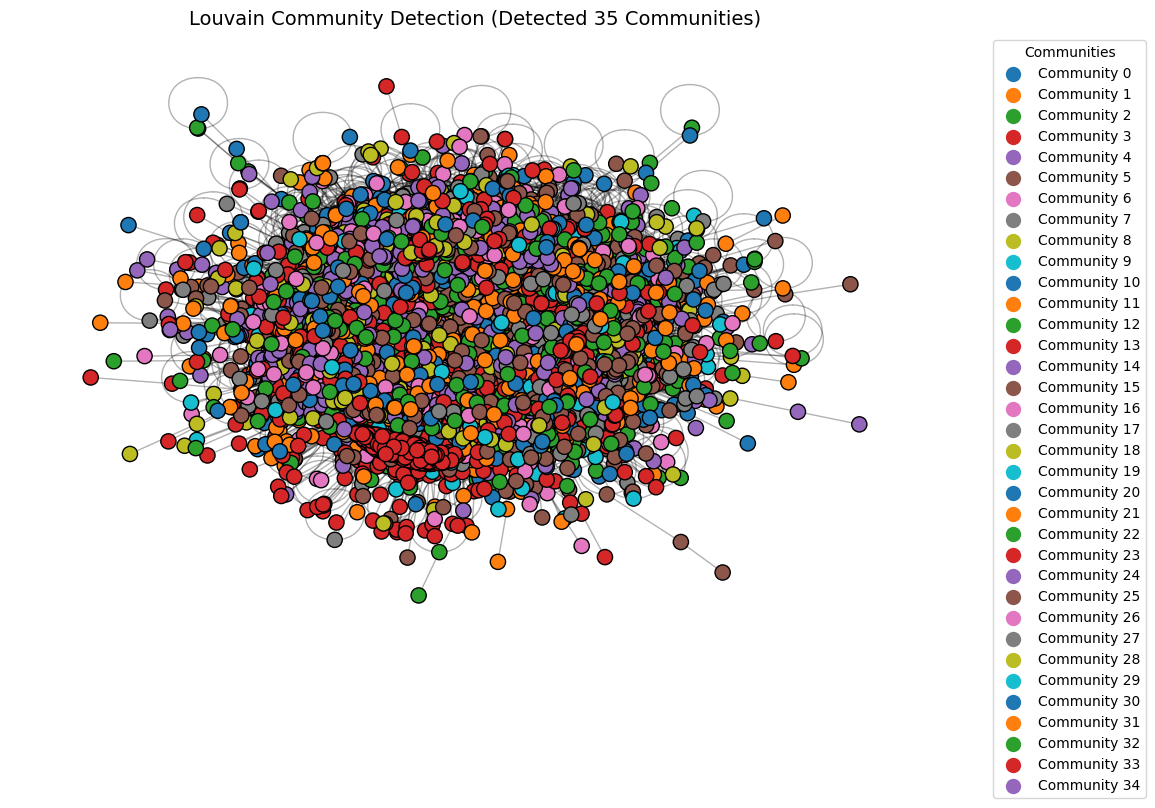

In [ ]:
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
import pickle  # For saving/loading data
import matplotlib.pyplot as plt
import seaborn as sns  # Better color palettes

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
community_labels_file = base_path + "community_labels.csv"
community_composition_file = base_path + "community_composition.csv"

# Load edgelist
edges = pd.read_csv(edgelist_file)

# Create graph from edgelist
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract the largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Apply Louvain OR load from saved file
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("Louvain partition computed and saved.")

# Count number of detected communities
num_communities = len(set(partition.values()))
print(f"Louvain detected {num_communities} communities in the network.")

# Convert partition data to a DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# Load labeled nodes (convert column names to lowercase)
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]
labels_list = [pd.read_csv(base_path + file) for file in label_files]
labels = pd.concat(labels_list)
labels.columns = labels.columns.str.lower()  # Normalize column names

# Ensure required columns exist
if 'node' not in labels.columns or 'label' not in labels.columns:
    raise ValueError("The label files must contain 'Node' and 'Label' columns.")

# Merge community assignments with labels
partition_df = partition_df.merge(labels, on='node', how='left')

# Analyze label distribution within each community
community_composition = partition_df.groupby(['community', 'label']).size().unstack(fill_value=0)

# Save results
partition_df.to_csv(community_labels_file, index=False)
community_composition.to_csv(community_composition_file)

# Print summary of community composition
print("Community Composition:")
print(community_composition)

# --- Enhanced Visualization ---
plt.figure(figsize=(12, 8))

# Compute node positions
pos = nx.spring_layout(G, seed=42)

# Generate distinct colors for each community
unique_communities = set(partition.values())
palette = sns.color_palette("tab10", len(unique_communities))  # Tab10 for distinct colors
community_colors = {comm: palette[i] for i, comm in enumerate(unique_communities)}

# Assign colors based on communities
node_colors = [community_colors[partition[node]] for node in G.nodes()]

# Draw edges with transparency
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw nodes with assigned colors, larger size, and black edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, edgecolors="black")

# Add a legend mapping colors to communities
legend_labels = {f"Community {comm}": color for comm, color in community_colors.items()}
for label, color in legend_labels.items():
    plt.scatter([], [], color=color, label=label, s=100)

plt.legend(title="Communities", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title(f"Louvain Community Detection (Detected {num_communities} Communities)", fontsize=14)
plt.axis("off")  # Remove axis for clarity
plt.show()



✅ Loaded Louvain partition from saved file.

🔹 Analyzing: veg_nodes_labeled.csv
🔝 Top 3 labels per community:
label      vegetarian  omnivorous
community                        
0            0.578947    0.421053
1            0.611518    0.388482
2            0.620123    0.379877
3            0.628921    0.371079
4            0.627211    0.372789
5            0.608146    0.391854
6            0.618357    0.381643
7            0.610831    0.389169
8            0.634921    0.365079
9            0.558704    0.441296
10           0.577371    0.422629
11           0.584233    0.415767
12           0.633552    0.366448
13           0.663974    0.336026
14           0.606742    0.393258
15           0.622857    0.377143
16           0.601695    0.398305
17           0.664286    0.335714
18           0.614458    0.385542
19           0.594059    0.405941
20           0.575342    0.424658
21           0.604966    0.395034
22           0.674051    0.325949
23           0.700535    0.299465
24    

<Figure size 1200x600 with 0 Axes>

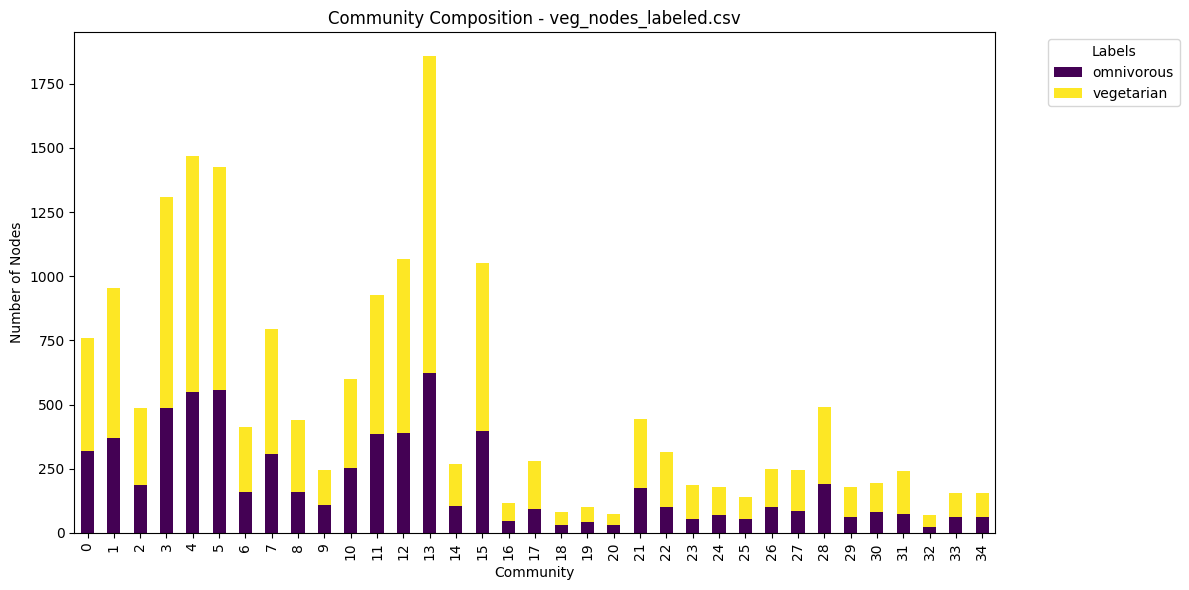


🔹 Analyzing: swe_nodes_labeled.csv
🔝 Top 3 labels per community:
label        savory     sweet
community                    
0          0.897368  0.102632
1          0.878534  0.121466
2          0.880903  0.119097
3          0.870696  0.129304
4          0.895238  0.104762
5          0.892556  0.107444
6          0.859903  0.140097
7          0.911839  0.088161
8          0.900227  0.099773
9          0.939271  0.060729
10         0.921797  0.078203
11         0.894168  0.105832
12         0.880975  0.119025
13         0.901992  0.098008
14         0.898876  0.101124
15         0.900000  0.100000
16         0.872881  0.127119
17         0.853571  0.146429
18         0.951807  0.048193
19         0.841584  0.158416
20         0.835616  0.164384
21         0.878104  0.121896
22         0.901899  0.098101
23         0.877005  0.122995
24         0.882022  0.117978
25         0.879433  0.120567
26         0.891566  0.108434
27         0.897541  0.102459
28         0.924490  0.075510
29  

<Figure size 1200x600 with 0 Axes>

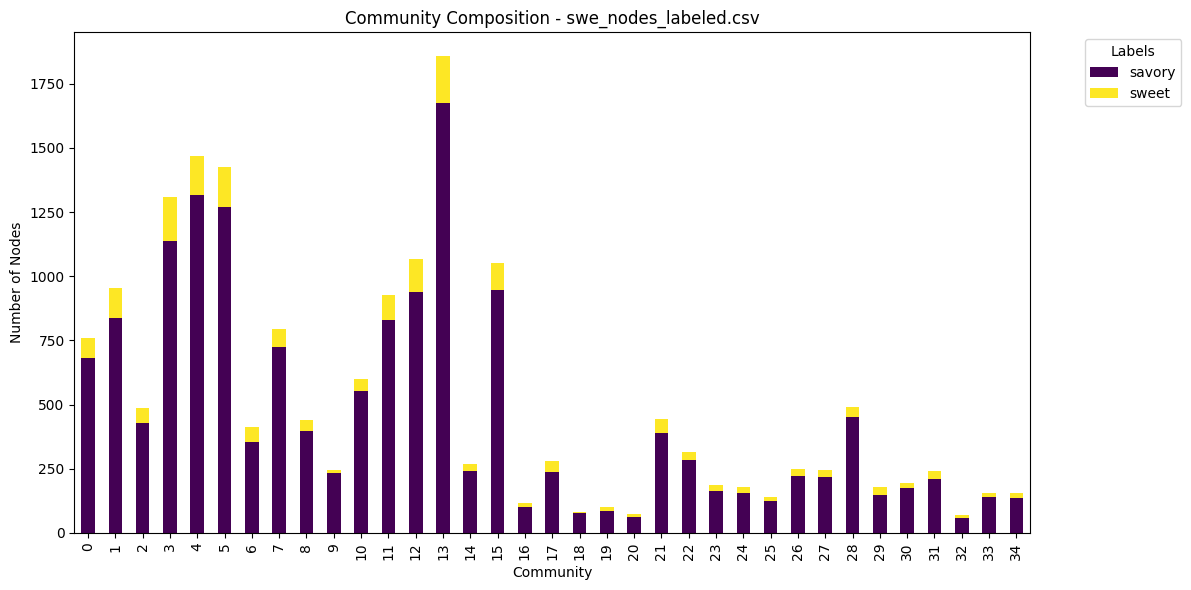


🔹 Analyzing: tag_nodes_labeled.csv
🔝 Top 3 labels per community:
label           1.0       0.0
community                    
0          0.771053  0.228947
1          0.801047  0.198953
2          0.819302  0.180698
3          0.845448  0.154552
4          0.802721  0.197279
5          0.849017  0.150983
6          0.809179  0.190821
7          0.808564  0.191436
8          0.791383  0.208617
9          0.805668  0.194332
10         0.797005  0.202995
11         0.806695  0.193305
12         0.807873  0.192127
13         0.738826  0.261174
14         0.786517  0.213483
15         0.801905  0.198095
16         0.830508  0.169492
17         0.825000  0.175000
18         0.927711  0.072289
19         0.762376  0.237624
20         0.739726  0.260274
21         0.821670  0.178330
22         0.800633  0.199367
23         0.796791  0.203209
24         0.848315  0.151685
25         0.879433  0.120567
26         0.787149  0.212851
27         0.836066  0.163934
28         0.822449  0.177551
29  

<Figure size 1200x600 with 0 Axes>

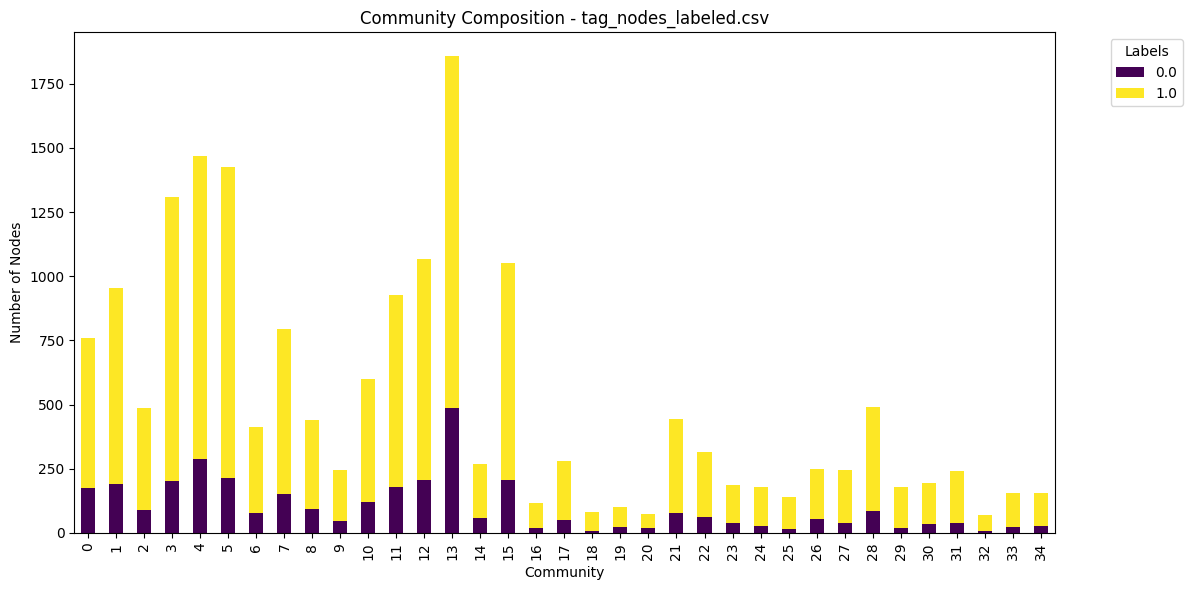


🔹 Analyzing: eth_nodes_labeled.csv
🔝 Top 3 labels per community:
label      American   Chinese    French   Italian    Middle
community                                                  
0          0.477632  0.240789  0.090789       NaN       NaN
1          0.524607  0.223037  0.080628       NaN       NaN
2          0.511294  0.195072  0.102669       NaN       NaN
3          0.515685  0.221117  0.087223       NaN       NaN
4          0.521769  0.193878  0.092517       NaN       NaN
5          0.515449  0.221208  0.090590       NaN       NaN
6          0.543478  0.176329  0.079710       NaN       NaN
7          0.530227  0.181360  0.090680       NaN       NaN
8          0.539683  0.156463  0.081633       NaN       NaN
9          0.558704  0.186235  0.085020       NaN       NaN
10         0.482529  0.224626  0.101498       NaN       NaN
11         0.514039  0.188985  0.106911       NaN       NaN
12         0.521087  0.184630  0.105904       NaN       NaN
13         0.522886  0.190092  0.0

<ipython-input-5-1ca4acd4e361>:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

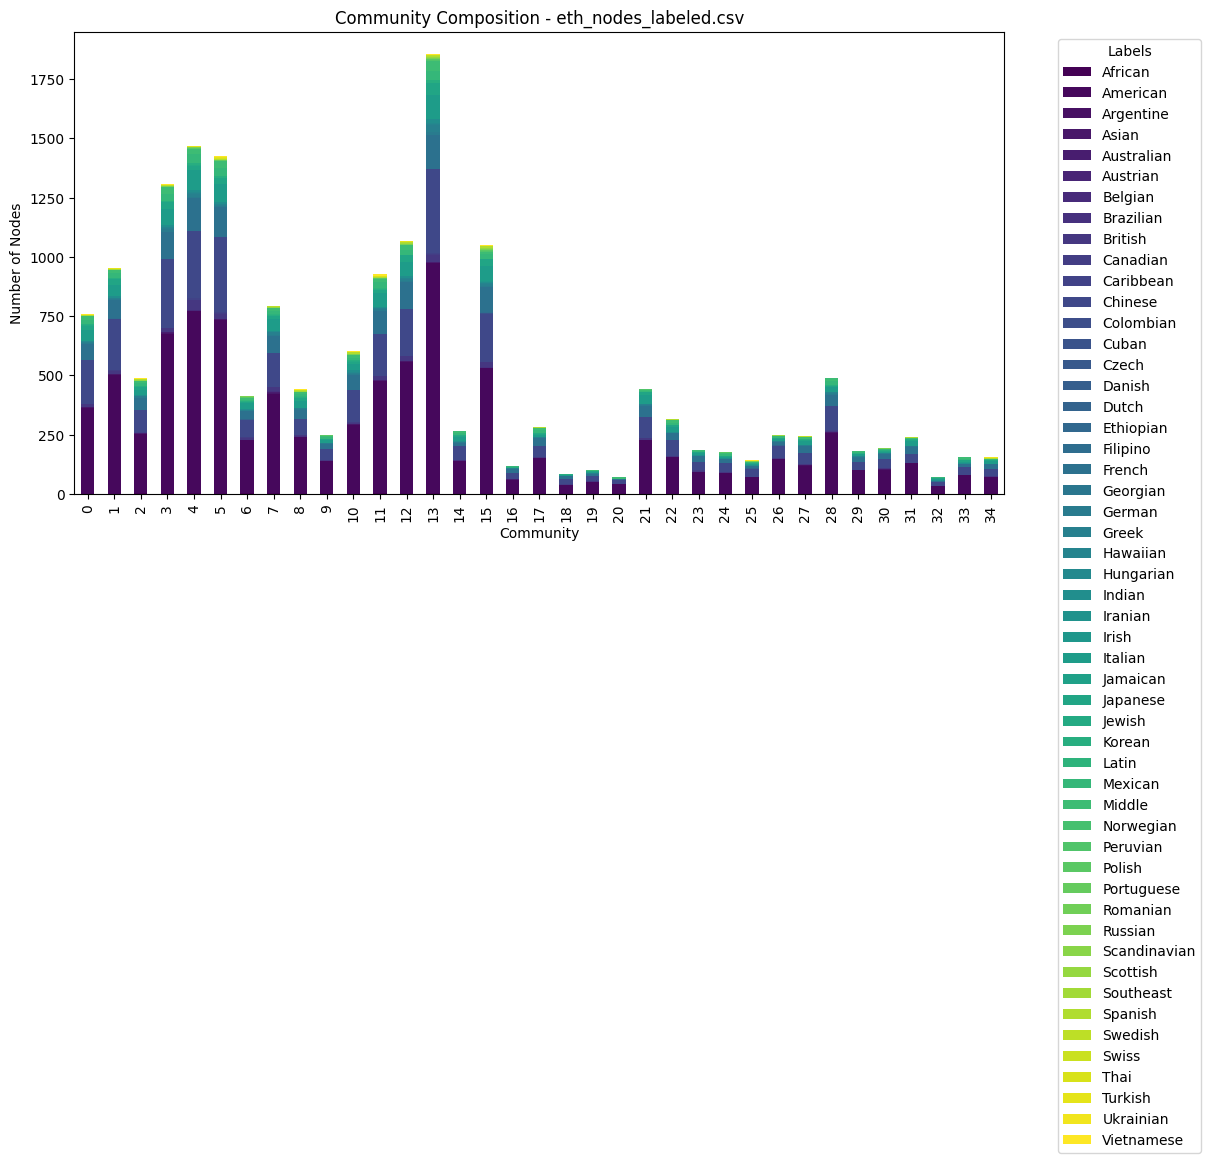

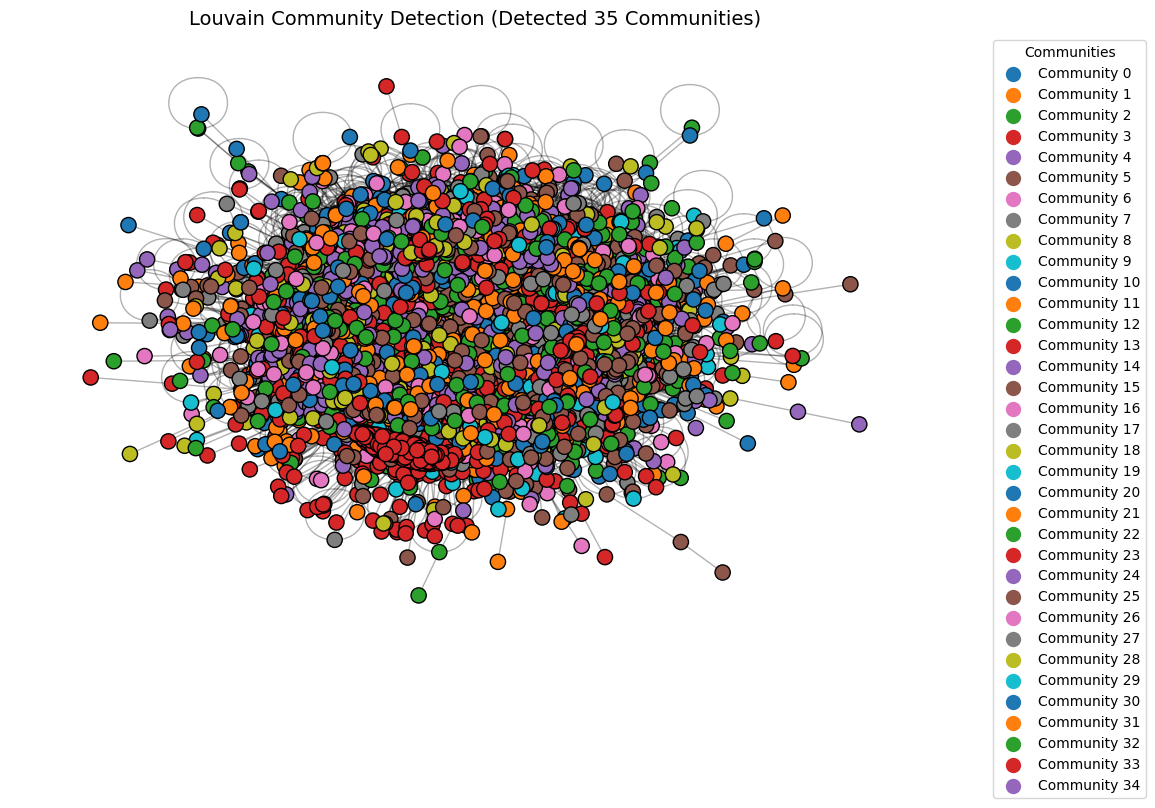

In [ ]:
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
import pickle  # For saving/loading data
import matplotlib.pyplot as plt
import seaborn as sns  # Better color palettes

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
community_labels_file = base_path + "community_labels.csv"

# Load edgelist & construct the graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Apply Louvain or load from saved file
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("✅ Louvain partition computed and saved.")

# Convert partition results to a DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# List of label files
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Function to analyze each label file separately
def analyze_label_file(label_file):
    print(f"\n🔹 Analyzing: {label_file}")

    # Load label data
    labels = pd.read_csv(base_path + label_file)
    labels.columns = labels.columns.str.lower()  # Normalize column names

    # Handle variations in column names
    if 'classification' in labels.columns:
        labels.rename(columns={'classification': 'label'}, inplace=True)

    # Merge with community assignments
    merged_df = partition_df.merge(labels, on='node', how='left')

    # Ensure label column exists after merging
    if 'label' not in merged_df.columns:
        raise ValueError(f"❌ Error: 'label' column is missing after merging {label_file}")

    # Compute label distribution per community
    community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)

    # Save results
    community_composition.to_csv(f"{base_path}community_composition_{label_file}.csv")

    # Print top 3 labels per community
    print("🔝 Top 3 labels per community:")
    top_labels = community_composition.div(community_composition.sum(axis=1), axis=0).apply(lambda x: x.nlargest(3), axis=1)
    print(top_labels)

    # Visualization - Stacked Bar Chart
    plt.figure(figsize=(12, 6))
    community_composition.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
    plt.title(f"Community Composition - {label_file}")
    plt.ylabel("Number of Nodes")
    plt.xlabel("Community")
    plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Iterate over each label file and analyze separately
for label_file in label_files:
    analyze_label_file(label_file)

# --- Community Graph Visualization ---
plt.figure(figsize=(12, 8))

# Compute node positions
pos = nx.spring_layout(G, seed=42)

# Generate distinct colors for each community
unique_communities = set(partition.values())
palette = sns.color_palette("tab10", len(unique_communities))  # Tab10 for distinct colors
community_colors = {comm: palette[i] for i, comm in enumerate(unique_communities)}

# Assign colors based on communities
node_colors = [community_colors[partition[node]] for node in G.nodes()]

# Draw edges with transparency
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw nodes with assigned colors
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, edgecolors="black")

# Add a legend mapping colors to communities
legend_labels = {f"Community {comm}": color for comm, color in community_colors.items()}
for label, color in legend_labels.items():
    plt.scatter([], [], color=color, label=label, s=100)

plt.legend(title="Communities", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title(f"Louvain Community Detection (Detected {len(unique_communities)} Communities)", fontsize=14)
plt.axis("off")  # Remove axis for clarity
plt.show()


Removed file names from plot titles.

Updated label mappings:

0.0 → "I Ate"

1.0 → "Home Made"

✅ Loaded Louvain partition from saved file.

🔹 Analyzing: veg_nodes_labeled.csv
🔝 Top 3 labels per community:
label      vegetarian  omnivorous
community                        
0            0.578947    0.421053
1            0.611518    0.388482
2            0.620123    0.379877
3            0.628921    0.371079
4            0.627211    0.372789
5            0.608146    0.391854
6            0.618357    0.381643
7            0.610831    0.389169
8            0.634921    0.365079
9            0.558704    0.441296
10           0.577371    0.422629
11           0.584233    0.415767
12           0.633552    0.366448
13           0.663974    0.336026
14           0.606742    0.393258
15           0.622857    0.377143
16           0.601695    0.398305
17           0.664286    0.335714
18           0.614458    0.385542
19           0.594059    0.405941
20           0.575342    0.424658
21           0.604966    0.395034
22           0.674051    0.325949
23           0.700535    0.299465
24    

<Figure size 1200x600 with 0 Axes>

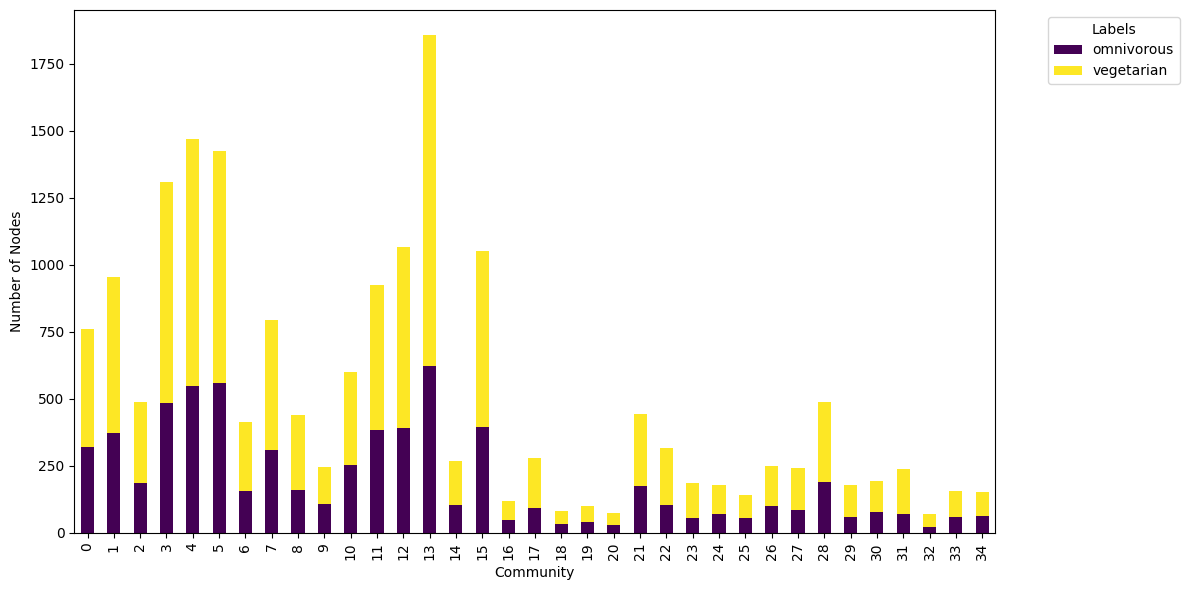


🔹 Analyzing: swe_nodes_labeled.csv
🔝 Top 3 labels per community:
label        savory     sweet
community                    
0          0.897368  0.102632
1          0.878534  0.121466
2          0.880903  0.119097
3          0.870696  0.129304
4          0.895238  0.104762
5          0.892556  0.107444
6          0.859903  0.140097
7          0.911839  0.088161
8          0.900227  0.099773
9          0.939271  0.060729
10         0.921797  0.078203
11         0.894168  0.105832
12         0.880975  0.119025
13         0.901992  0.098008
14         0.898876  0.101124
15         0.900000  0.100000
16         0.872881  0.127119
17         0.853571  0.146429
18         0.951807  0.048193
19         0.841584  0.158416
20         0.835616  0.164384
21         0.878104  0.121896
22         0.901899  0.098101
23         0.877005  0.122995
24         0.882022  0.117978
25         0.879433  0.120567
26         0.891566  0.108434
27         0.897541  0.102459
28         0.924490  0.075510
29  

<Figure size 1200x600 with 0 Axes>

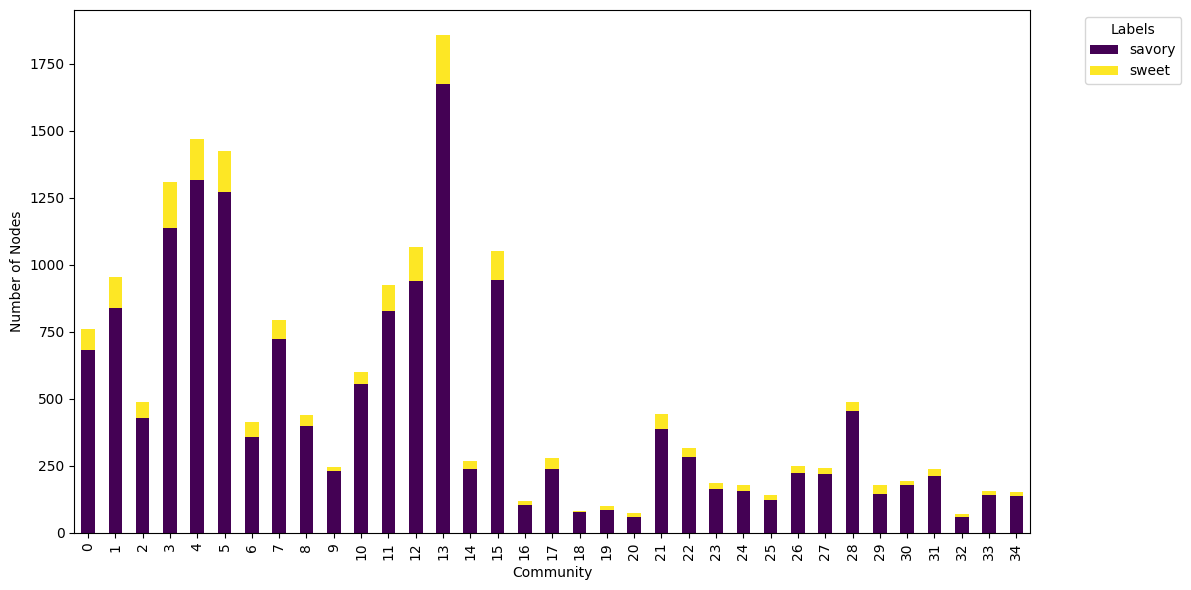


🔹 Analyzing: tag_nodes_labeled.csv
🔝 Top 3 labels per community:
label      Homemade     I Ate
community                    
0          0.771053  0.228947
1          0.801047  0.198953
2          0.819302  0.180698
3          0.845448  0.154552
4          0.802721  0.197279
5          0.849017  0.150983
6          0.809179  0.190821
7          0.808564  0.191436
8          0.791383  0.208617
9          0.805668  0.194332
10         0.797005  0.202995
11         0.806695  0.193305
12         0.807873  0.192127
13         0.738826  0.261174
14         0.786517  0.213483
15         0.801905  0.198095
16         0.830508  0.169492
17         0.825000  0.175000
18         0.927711  0.072289
19         0.762376  0.237624
20         0.739726  0.260274
21         0.821670  0.178330
22         0.800633  0.199367
23         0.796791  0.203209
24         0.848315  0.151685
25         0.879433  0.120567
26         0.787149  0.212851
27         0.836066  0.163934
28         0.822449  0.177551
29  

<Figure size 1200x600 with 0 Axes>

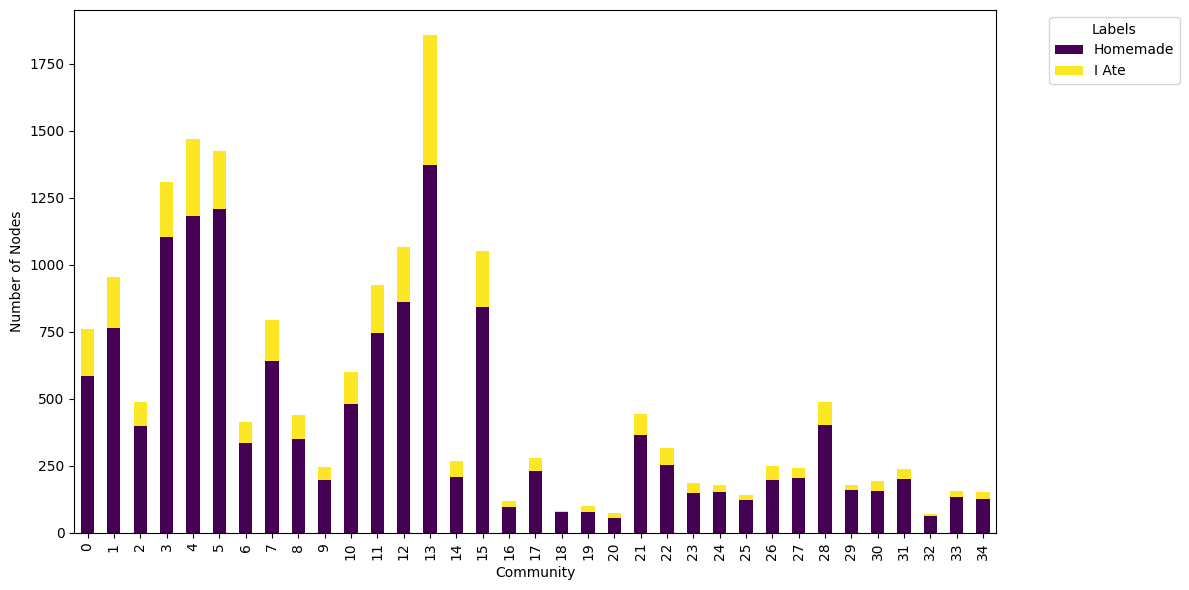


🔹 Analyzing: eth_nodes_labeled.csv
🔝 Top 3 labels per community:
label      American   Chinese    French   Italian    Middle
community                                                  
0          0.477632  0.240789  0.090789       NaN       NaN
1          0.524607  0.223037  0.080628       NaN       NaN
2          0.511294  0.195072  0.102669       NaN       NaN
3          0.515685  0.221117  0.087223       NaN       NaN
4          0.521769  0.193878  0.092517       NaN       NaN
5          0.515449  0.221208  0.090590       NaN       NaN
6          0.543478  0.176329  0.079710       NaN       NaN
7          0.530227  0.181360  0.090680       NaN       NaN
8          0.539683  0.156463  0.081633       NaN       NaN
9          0.558704  0.186235  0.085020       NaN       NaN
10         0.482529  0.224626  0.101498       NaN       NaN
11         0.514039  0.188985  0.106911       NaN       NaN
12         0.521087  0.184630  0.105904       NaN       NaN
13         0.522886  0.190092  0.0

<ipython-input-9-a66cf3984b3f>:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

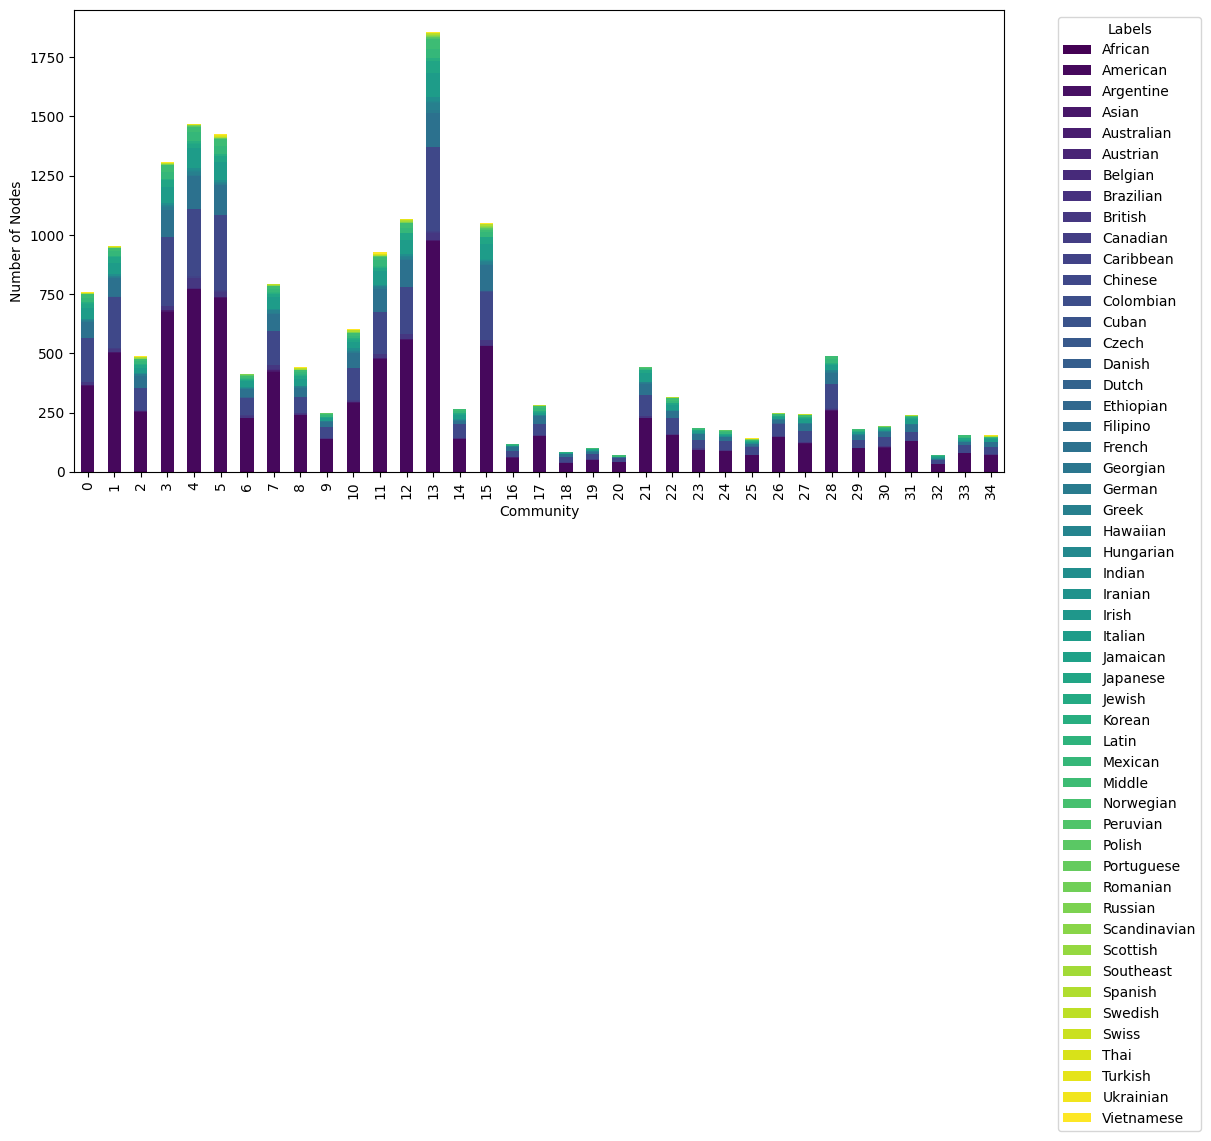

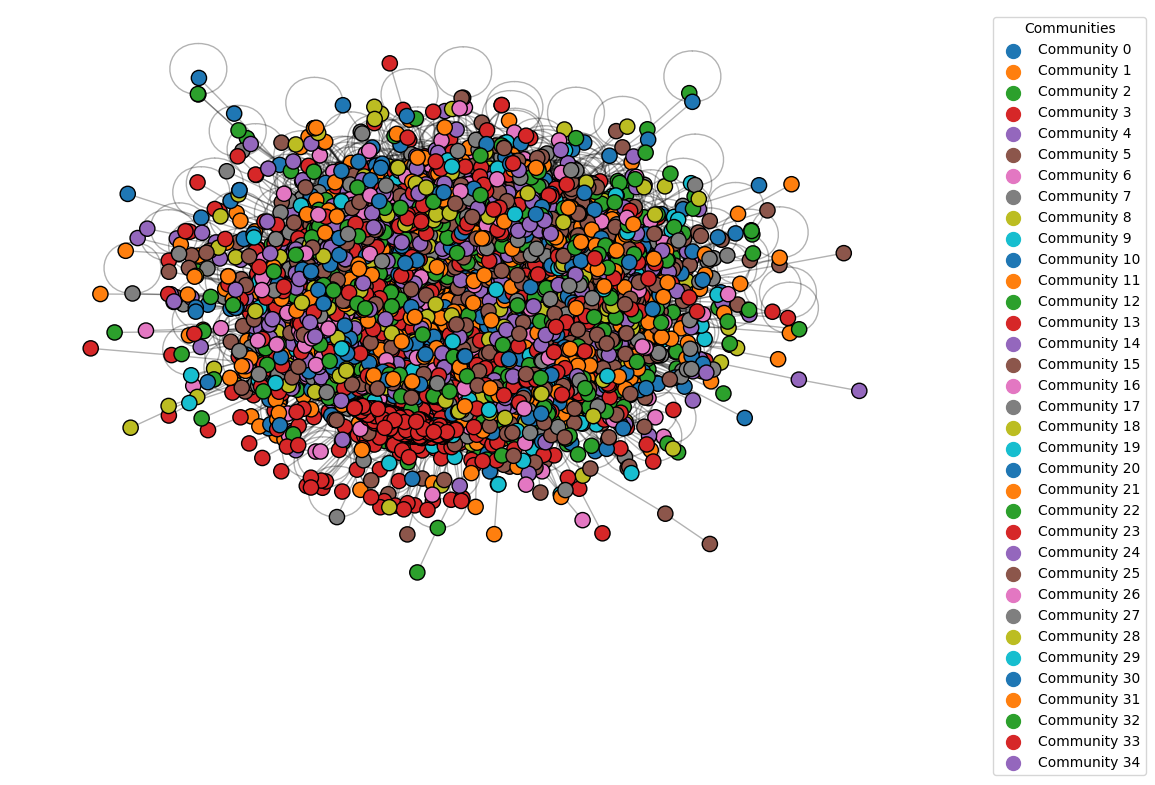

In [9]:
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
import pickle  # For saving/loading data
import matplotlib.pyplot as plt
import seaborn as sns  # Better color palettes

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"

# Load edgelist & construct the graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Apply Louvain or load from saved file
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("✅ Louvain partition computed and saved.")

# Convert partition results to a DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# Label files
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Function to analyze each label file separately
def analyze_label_file(label_file):
    print(f"\n🔹 Analyzing: {label_file}")

    # Load label data
    labels = pd.read_csv(base_path + label_file)
    labels.columns = labels.columns.str.lower()  # Normalize column names

    # Handle variations in column names
    if 'classification' in labels.columns:
        labels.rename(columns={'classification': 'label'}, inplace=True)

    # Apply label mapping **only for tag_nodes_labeled.csv**
    if label_file == "tag_nodes_labeled.csv":
        label_mapping = {0.0: "I Ate", 1.0: "Homemade"}
        labels['label'] = labels['label'].map(label_mapping).fillna(labels['label'])

    # Merge with community assignments
    merged_df = partition_df.merge(labels, on='node', how='left')

    # Ensure label column exists after merging
    if 'label' not in merged_df.columns:
        raise ValueError(f"❌ Error: 'label' column is missing after merging {label_file}")

    # Compute label distribution per community
    community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)

    # Save results
    community_composition.to_csv(f"{base_path}community_composition_{label_file}.csv")

    # Print top 3 labels per community
    print("🔝 Top 3 labels per community:")
    top_labels = community_composition.div(community_composition.sum(axis=1), axis=0).apply(lambda x: x.nlargest(3), axis=1)
    print(top_labels)

    # Visualization - Stacked Bar Chart
    plt.figure(figsize=(12, 6))
    community_composition.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
    plt.ylabel("Number of Nodes")
    plt.xlabel("Community")
    plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Iterate over each label file and analyze separately
for label_file in label_files:
    analyze_label_file(label_file)

# --- Community Graph Visualization ---
plt.figure(figsize=(12, 8))

# Compute node positions
pos = nx.spring_layout(G, seed=42)

# Generate distinct colors for each community
unique_communities = set(partition.values())
palette = sns.color_palette("tab10", len(unique_communities))  # Tab10 for distinct colors
community_colors = {comm: palette[i] for i, comm in enumerate(unique_communities)}

# Assign colors based on communities
node_colors = [community_colors[partition[node]] for node in G.nodes()]

# Draw edges with transparency
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw nodes with assigned colors
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, edgecolors="black")

# Add a legend mapping colors to communities
legend_labels = {f"Community {comm}": color for comm, color in community_colors.items()}
for label, color in legend_labels.items():
    plt.scatter([], [], color=color, label=label, s=100)

plt.legend(title="Communities", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.axis("off")  # Remove axis for clarity
plt.show()



In [ ]:
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Load edgelist and create graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Load or compute Louvain partition
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("✅ Louvain partition computed and saved.")

num_communities = len(set(partition.values()))
print(f"📌 Louvain detected {num_communities} communities in the network.")

# Convert partition to DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# Process each label file separately
for label_file in label_files:
    # Load label file
    labels = pd.read_csv(base_path + label_file)
    labels.columns = labels.columns.str.lower()

    # Handle variations in column names
    if 'classification' in labels.columns:
        labels.rename(columns={'classification': 'label'}, inplace=True)

    if 'label' not in labels.columns:
        raise ValueError(f"❌ The file {label_file} does not contain a 'label' column.")

    # Merge labels with partition
    merged_df = partition_df.merge(labels, on='node', how='left')

    # Compute community composition
    community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)

    # Identify the majority label in each community
    majority_labels = community_composition.idxmax(axis=1)

    # Print label counts
    print(f"\n📂 Label counts for {label_file}:")
    print(labels['label'].value_counts())
    print("-" * 40)

    # --- Visualization ---
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)

    # Generate distinct colors for each community
    unique_communities = set(partition.values())
    palette = sns.color_palette("tab10", len(unique_communities))
    community_colors = {comm: palette[i] for i, comm in enumerate(unique_communities)}

    # Assign colors based on communities
    node_colors = [community_colors[partition[node]] for node in G.nodes()]

    # Draw edges with transparency
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes with assigned colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, edgecolors="black")

    # Add majority label as a text annotation
    for comm, label in majority_labels.items():
        x, y = pos[list(partition.keys())[list(partition.values()).index(comm)]]
        plt.text(x, y, label, fontsize=9, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.7))

    # Add a legend
    legend_labels = {f"Community {comm}": color for comm, color in community_colors.items()}
    for label, color in legend_labels.items():
        plt.scatter([], [], color=color, label=label, s=100)

    plt.legend(title="Communities", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(f"Louvain Community Detection ({label_file})", fontsize=14)
    plt.axis("off")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

final code with  louvain community detections, with nodes, histograms and label names for each community

In [ ]:
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Load edgelist and create graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Load or compute Louvain partition
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("✅ Louvain partition computed and saved.")

num_communities = len(set(partition.values()))
print(f"📌 Louvain detected {num_communities} communities in the network.")

# Convert partition to DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# Compute layout positions once
pos = nx.spring_layout(G, seed=42)

# Process each label file separately
for label_file in label_files:
    # Load label file
    labels = pd.read_csv(base_path + label_file)
    labels.columns = labels.columns.str.lower()

    # Handle variations in column names
    if 'classification' in labels.columns:
        labels.rename(columns={'classification': 'label'}, inplace=True)

    if 'label' not in labels.columns:
        raise ValueError(f"❌ The file {label_file} does not contain a 'label' column.")

    # Merge labels with partition
    merged_df = partition_df.merge(labels, on='node', how='left')

    # Compute community composition
    community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)

    # Identify the majority label in each community
    majority_labels = community_composition.idxmax(axis=1)

    # Print label counts
    print(f"\n📂 Label counts for {label_file}:")
    print(labels['label'].value_counts())
    print("-" * 40)

    # --- Visualization: Label Distribution ---
    plt.figure(figsize=(12, 6))
    community_composition.plot(kind='bar', stacked=True, colormap='tab10', figsize=(12, 6))
    plt.xlabel("Community")
    plt.ylabel("Number of Nodes")
    plt.title(f"Community Composition for {label_file}")
    plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # --- Visualization: Louvain Community Plot ---
    plt.figure(figsize=(12, 8))

    # Generate distinct colors for each community
    unique_communities = set(partition.values())
    palette = sns.color_palette("tab10", len(unique_communities))
    community_colors = {comm: palette[i] for i, comm in enumerate(unique_communities)}

    # Assign colors based on communities
    node_colors = [community_colors[partition[node]] for node in G.nodes()]

    # Draw edges with transparency
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes with assigned colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, edgecolors="black")

    # Add majority label text at the correct position (center of each community)
    for comm in majority_labels.index:
        # Get nodes belonging to the community
        community_nodes = [node for node, c in partition.items() if c == comm]
        if community_nodes:
            # Compute the centroid of the community
            x_vals = [pos[node][0] for node in community_nodes]
            y_vals = [pos[node][1] for node in community_nodes]
            centroid_x, centroid_y = sum(x_vals) / len(x_vals), sum(y_vals) / len(y_vals)

            # Annotate the plot with the majority label
            plt.text(centroid_x, centroid_y, majority_labels[comm], fontsize=9, fontweight='bold',
                     ha='center', bbox=dict(facecolor='white', alpha=0.7))

    # Add a legend mapping colors to communities with majority labels
    legend_labels = {f"Community {comm} ({majority_labels.get(comm, 'N/A')})": color for comm, color in community_colors.items()}
    for label, color in legend_labels.items():
        plt.scatter([], [], color=color, label=label, s=100)

    plt.legend(title="Communities", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(f"Louvain Community Detection ({label_file})", fontsize=14)
    plt.axis("off")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Load edgelist and create graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Load or compute Louvain partition
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("✅ Louvain partition computed and saved.")

num_communities = len(set(partition.values()))
print(f"📌 Louvain detected {num_communities} communities in the network.")

# Convert partition to DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# Compute layout positions once
pos = nx.spring_layout(G, seed=42)

# Process each label file separately
for label_file in label_files:
    # Load label file
    labels = pd.read_csv(base_path + label_file)
    labels.columns = labels.columns.str.lower()

    # Handle variations in column names
    if 'classification' in labels.columns:
        labels.rename(columns={'classification': 'label'}, inplace=True)

    if 'label' not in labels.columns:
        raise ValueError(f"❌ The file {label_file} does not contain a 'label' column.")

    # Merge labels with partition
    merged_df = partition_df.merge(labels, on='node', how='left')

    # Compute community composition
    community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)

    # Identify the majority label in each community
    majority_labels = community_composition.idxmax(axis=1)

    # --- Louvain Community Plot with Regions ---
    plt.figure(figsize=(12, 8))

    # Generate distinct colors for each community
    unique_communities = set(partition.values())
    palette = sns.color_palette("tab10", len(unique_communities))
    community_colors = {comm: palette[i] for i, comm in enumerate(unique_communities)}

    # Draw convex hulls around each community
    for comm in majority_labels.index:
        community_nodes = [node for node, c in partition.items() if c == comm]
        if len(community_nodes) < 3:
            continue  # Need at least 3 points for a convex hull

        # Get node positions
        points = np.array([pos[node] for node in community_nodes])

        # Compute convex hull
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]

        # Draw shaded area
        plt.fill(hull_vertices[:, 0], hull_vertices[:, 1], alpha=0.3, color=community_colors[comm])

        # Compute centroid for labeling
        centroid_x, centroid_y = np.mean(hull_vertices, axis=0)

        # Annotate with majority label
        plt.text(centroid_x, centroid_y, majority_labels[comm], fontsize=10, fontweight='bold',
                 ha='center', bbox=dict(facecolor='white', alpha=0.8))

    # Draw edges with transparency
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes
    node_colors = [community_colors[partition[node]] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, edgecolors="black")

    # Add legend
    legend_labels = {f"Community {comm} ({majority_labels.get(comm, 'N/A')})": color for comm, color in community_colors.items()}
    for label, color in legend_labels.items():
        plt.scatter([], [], color=color, label=label, s=100)

    plt.legend(title="Communities", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(f"Louvain Community Detection ({label_file})", fontsize=14)
    plt.axis("off")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Normalization

✅ Normalizing each label count by dividing it by the total number of users in that label.
✅ Updating community compositions to reflect relative proportions instead of absolute counts.
✅ Plotting both raw and normalized distributions for better insight.

In [ ]:
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull
import community.community_louvain as community_louvain

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
pos_file = base_path + "graph_positions.pkl"
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Load edgelist and create graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract the largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Load or compute Louvain partition
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G, random_state=42)  # Ensures stable 35 communities
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("🆕 Louvain partition computed and saved.")

num_communities = len(set(partition.values()))
print(f"📌 Louvain detected {num_communities} communities.")

# Assign community to nodes
nx.set_node_attributes(G, partition, 'community')

# Load or compute graph positions
try:
    with open(pos_file, "rb") as f:
        pos = pickle.load(f)
    print("✅ Loaded graph positions from saved file.")
except FileNotFoundError:
    pos = nx.spring_layout(G, seed=42)  # Ensures consistent layout
    with open(pos_file, "wb") as f:
        pickle.dump(pos, f)
    print("🆕 Graph positions computed and saved.")

# Convert partition to DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# --- Process Each Label File ---
for label_file in label_files:
    try:
        labels = pd.read_csv(base_path + label_file)
        labels.columns = labels.columns.str.lower()
        if 'classification' in labels.columns:
            labels.rename(columns={'classification': 'label'}, inplace=True)
        if 'label' not in labels.columns:
            raise ValueError(f"❌ {label_file} missing 'label' column.")

        # Merge labels with community partition
        merged_df = partition_df.merge(labels, on='node', how='left')
        community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)
        majority_labels = community_composition.idxmax(axis=1)

        # --- Louvain Community Visualization ---
        plt.figure(figsize=(12, 8))
        palette = sns.color_palette("tab10", num_communities)
        community_colors = {comm: palette[i] for i, comm in enumerate(set(partition.values()))}

        for comm in majority_labels.index:
            community_nodes = [node for node, c in partition.items() if c == comm]
            if len(community_nodes) >= 3:
                points = np.array([pos[node] for node in community_nodes])
                hull = ConvexHull(points)
                hull_vertices = points[hull.vertices]
                plt.fill(hull_vertices[:, 0], hull_vertices[:, 1], alpha=0.3, color=community_colors[comm])
                centroid_x, centroid_y = np.mean(hull_vertices, axis=0)
                plt.text(centroid_x, centroid_y, majority_labels[comm], fontsize=10, fontweight='bold', ha='center',
                         bbox=dict(facecolor='white', alpha=0.8))

        nx.draw_networkx_edges(G, pos, alpha=0.3)
        nx.draw_networkx_nodes(G, pos, node_color=[community_colors[partition[node]] for node in G.nodes()],
                               node_size=120, edgecolors="black")

        plt.title(f"Louvain Community Detection ({label_file})", fontsize=14)
        plt.axis("off")
        plt.show()

        # --- Stacked Bar Chart (Normalized Community Composition) ---
        normalized_composition = community_composition.div(community_composition.sum(axis=1), axis=0)

        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        community_composition.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[0], legend=False)
        axes[0].set_title(f"Community Composition (Raw) - {label_file}")
        axes[0].set_ylabel("Node Count")
        axes[0].grid(axis="y", linestyle="--", alpha=0.7)

        normalized_composition.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1], legend=False)
        axes[1].set_title(f"Community Composition (Normalized) - {label_file}")
        axes[1].set_ylabel("Proportion")
        axes[1].grid(axis="y", linestyle="--", alpha=0.7)

        handles, labels = axes[1].get_legend_handles_labels()
        fig.legend(handles, labels, title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")

        plt.tight_layout()
        plt.show()

        # --- Histogram of Community Sizes ---
        plt.figure(figsize=(8, 5))
        sns.histplot(list(partition.values()), bins=num_communities, kde=False, color="skyblue", edgecolor="black")
        plt.title("Histogram of Community Sizes")
        plt.xlabel("Community ID")
        plt.ylabel("Node Count")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

    except Exception as e:
        print(f"⚠️ Error processing {label_file}: {e}")








Output hidden; open in https://colab.research.google.com to view.

✅ Normalizes label distributions so we can compare across different groups.
✅ Keeps the original Louvain community plot but now normalized.
✅ Plots heatmaps:

Raw distribution of labels across communities.
Normalized version (proportion of each label within its own category).
✅ Still highlights dominant labels in each community while considering relative size.

This ensures that larger groups don’t dominate conclusions just because they have more users.
If normalization doesn’t change results, it confirms homophily is structural rather than due to raw numbers.
If changes appear, it suggests label proportions skew interpretation.

✅ Loaded Louvain partition from saved file.
📌 Louvain detected 35 communities in the network.


/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


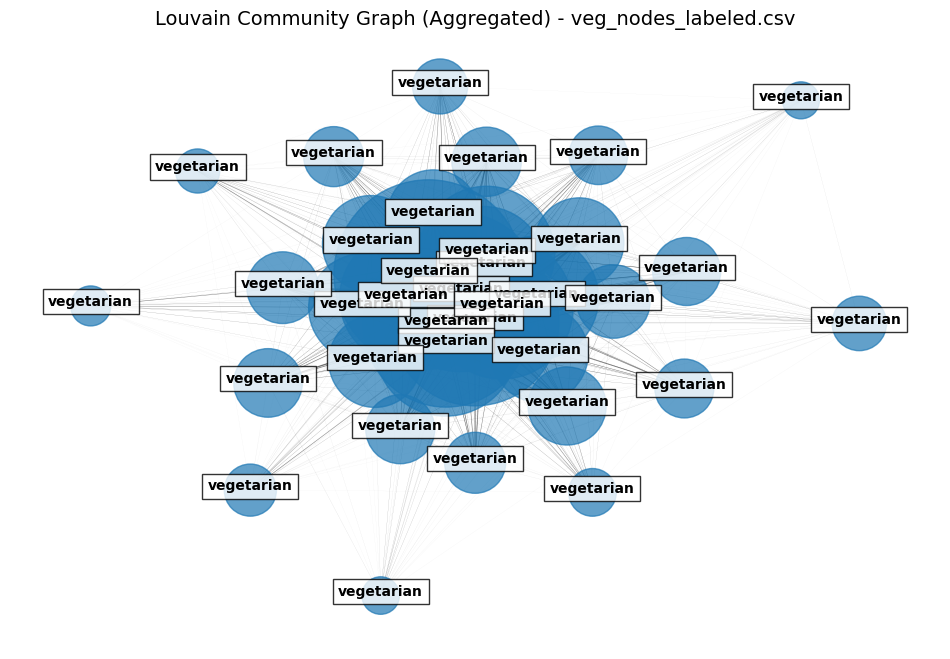

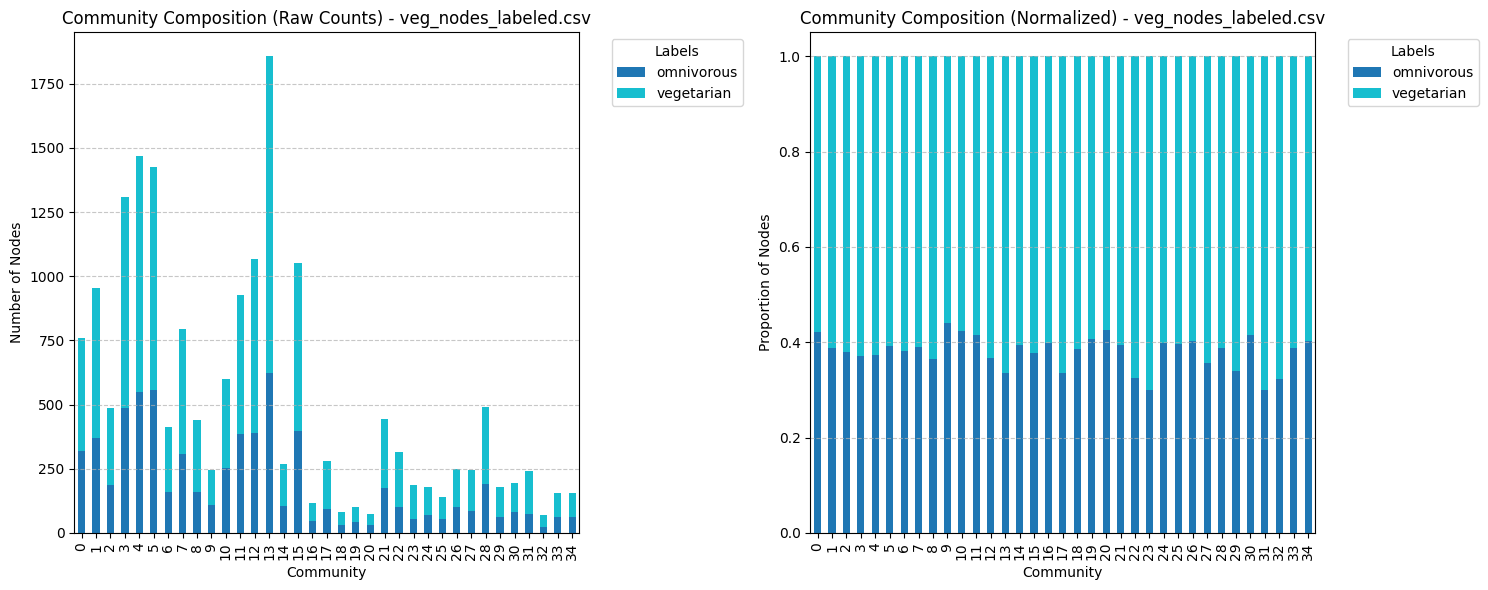

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


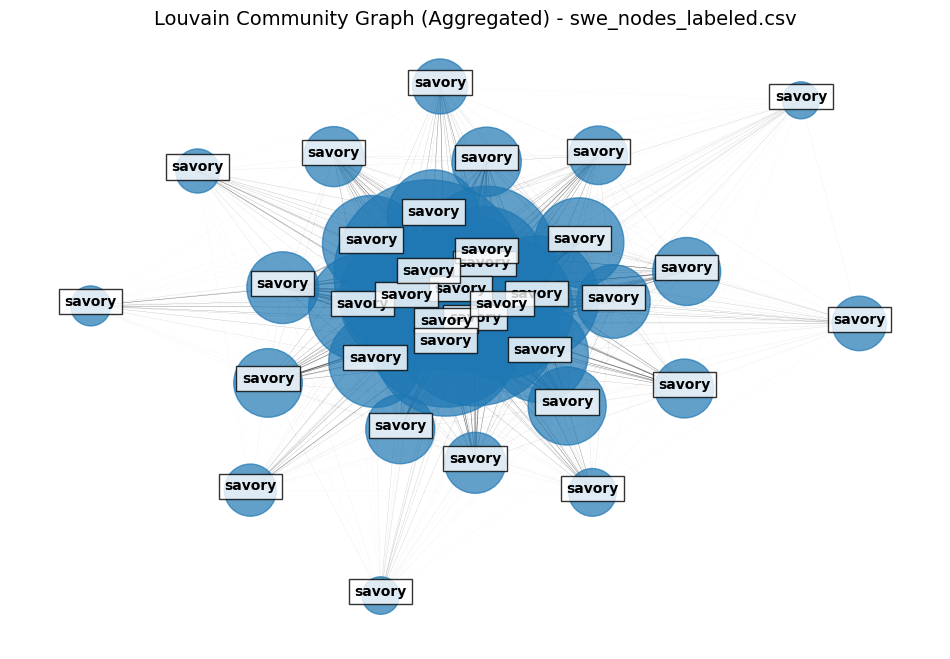

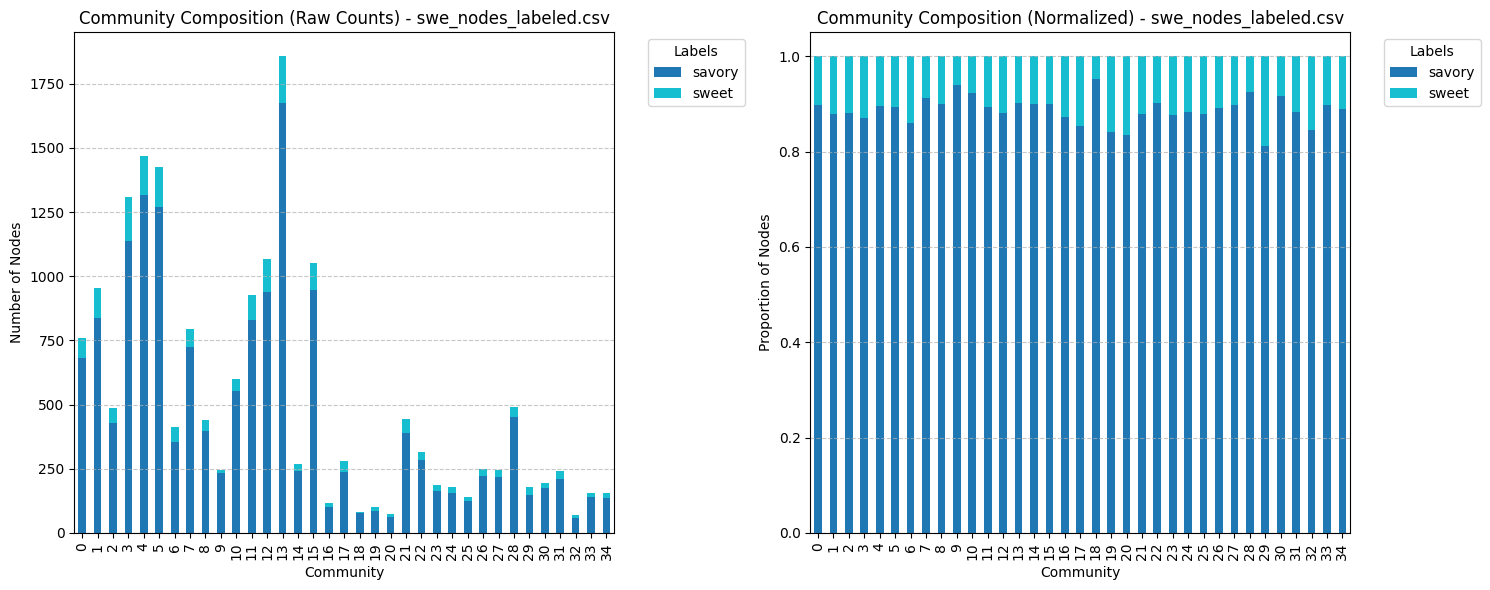

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


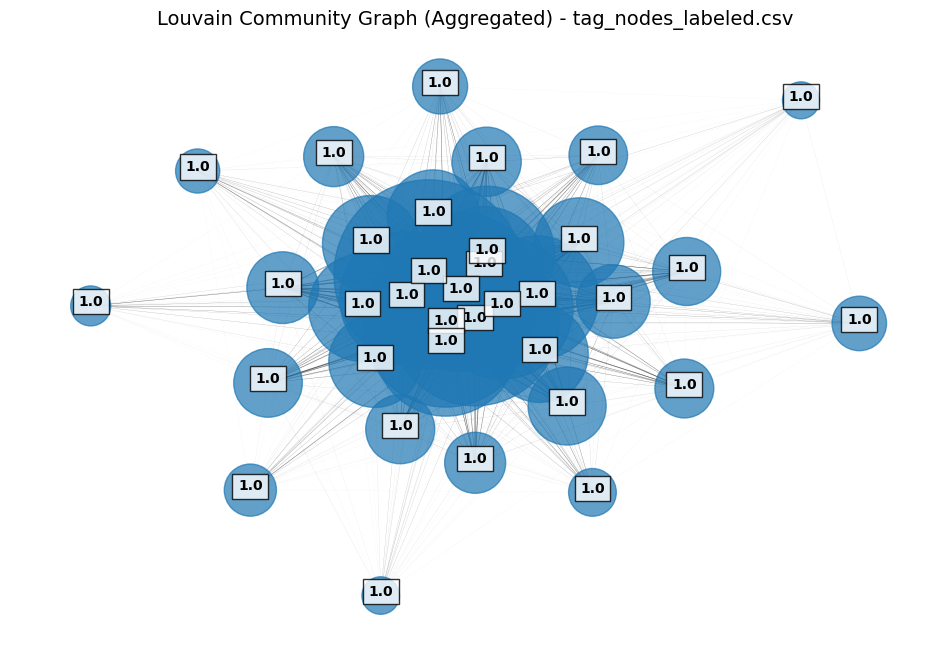

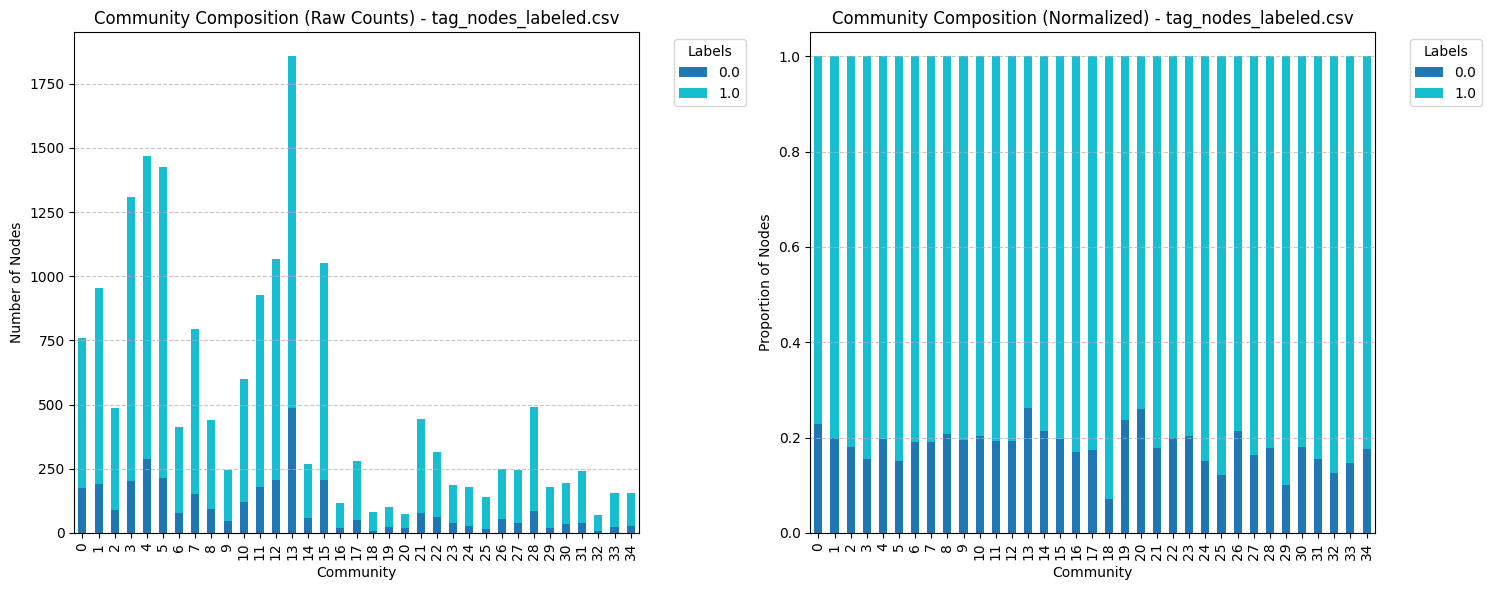

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


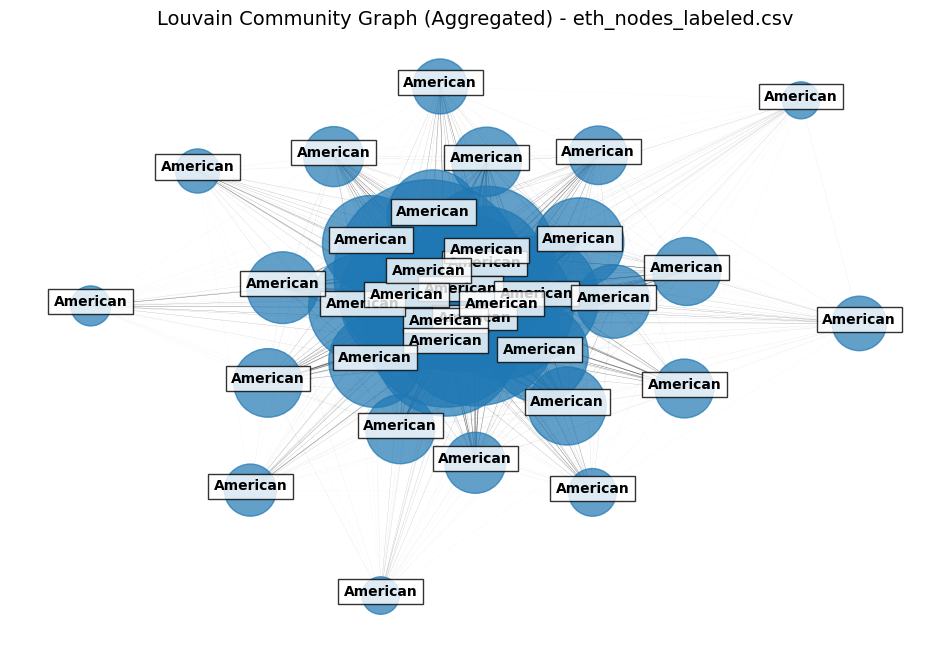

<ipython-input-8-f6799337ad7b>:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


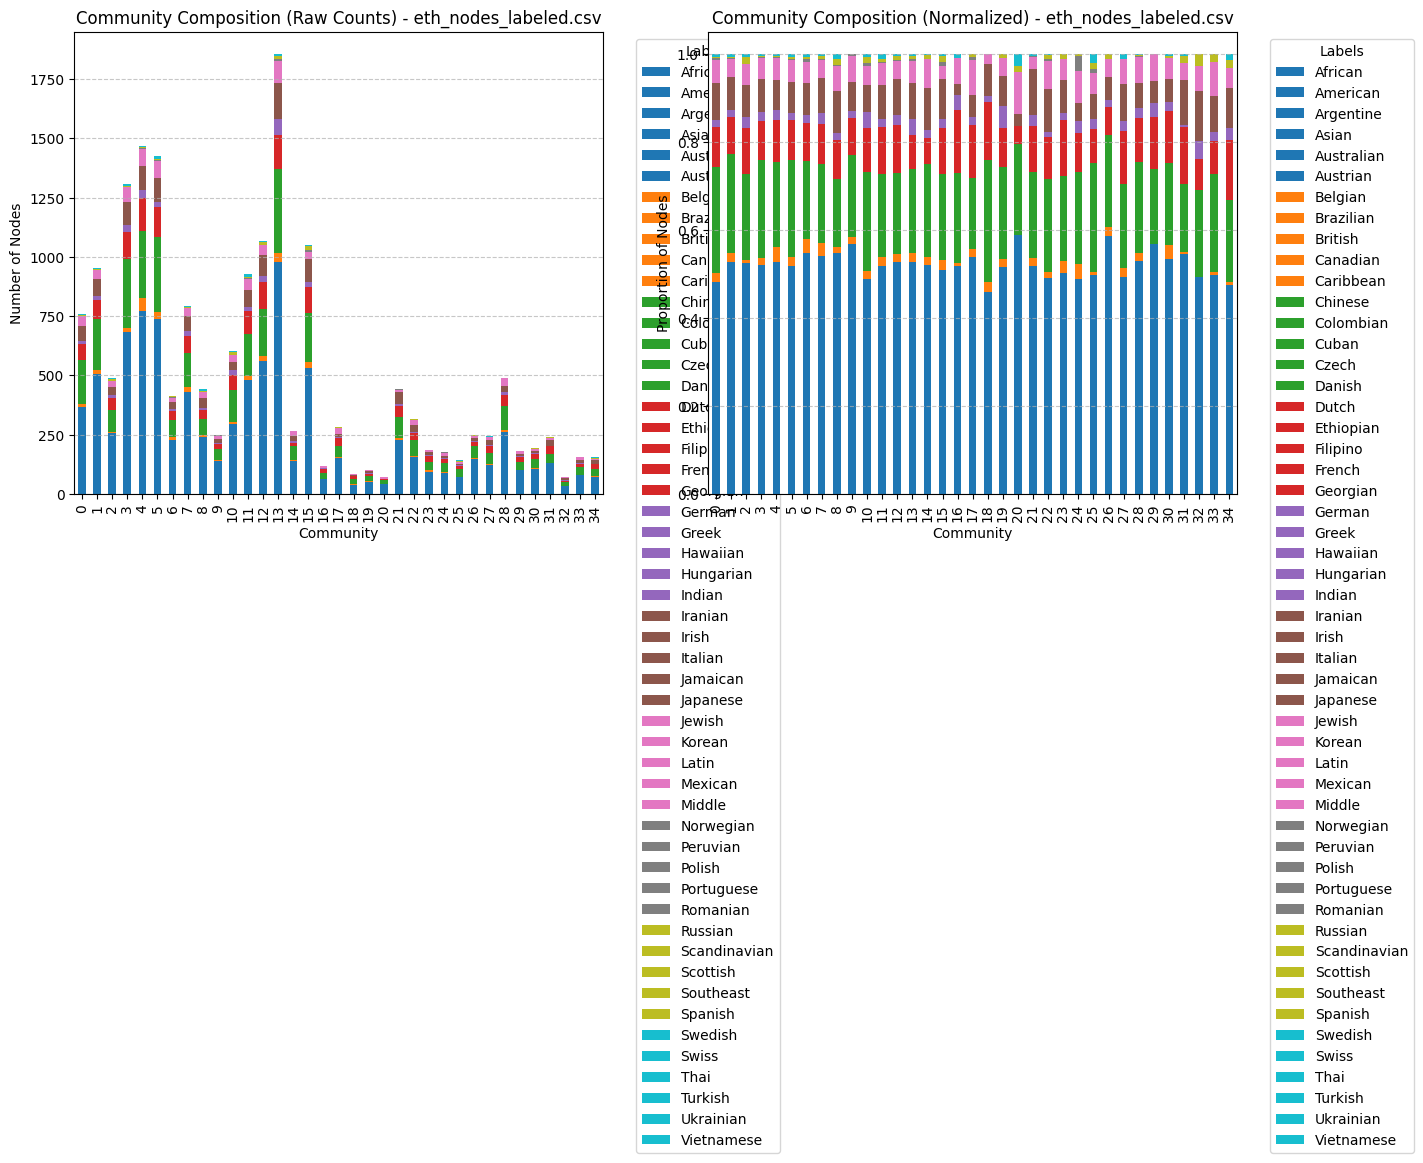

In [ ]:
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import community.community_louvain as community_louvain  # Ensure this is installed: `pip install python-louvain`

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Load edgelist and create graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Load or compute Louvain partition
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("✅ Louvain partition computed and saved.")

num_communities = len(set(partition.values()))
print(f"📌 Louvain detected {num_communities} communities in the network.")

# Convert partition to DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# Aggregate inter-community connections
community_edges = {}
for node1, node2 in G.edges():
    comm1, comm2 = partition[node1], partition[node2]
    if comm1 != comm2:
        community_edges[(comm1, comm2)] = community_edges.get((comm1, comm2), 0) + 1

# Process each label file separately
for label_file in label_files:
    try:
        # Load label file
        labels = pd.read_csv(base_path + label_file)
        labels.columns = labels.columns.str.lower()

        # Ensure 'node' column exists
        if 'node' not in labels.columns:
            raise ValueError(f"❌ The file {label_file} does not contain a 'node' column.")

        # Handle variations in column names
        if 'classification' in labels.columns:
            labels.rename(columns={'classification': 'label'}, inplace=True)

        if 'label' not in labels.columns:
            raise ValueError(f"❌ The file {label_file} does not contain a 'label' column.")

        # Merge labels with partition
        merged_df = partition_df.merge(labels, on='node', how='left')

        # Compute community composition (raw counts)
        community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)

        # Compute **normalized composition** (fractions per community)
        normalized_composition = community_composition.div(community_composition.sum(axis=1), axis=0)

        # Identify the majority label in each community
        majority_labels = community_composition.idxmax(axis=1)

        # --- Community Graph (Each Community as a Node) ---
        community_graph = nx.Graph()

        # Add nodes (one per community)
        for comm in majority_labels.index:
            community_size = community_composition.loc[comm].sum()
            community_graph.add_node(comm, size=community_size, label=majority_labels[comm])

        # Add edges (aggregated inter-community links)
        for (comm1, comm2), weight in community_edges.items():
            community_graph.add_edge(comm1, comm2, weight=weight)

        # Compute layout
        pos = nx.spring_layout(community_graph, seed=42)

        # Extract node sizes and labels
        node_sizes = [nx.get_node_attributes(community_graph, 'size')[n] * 10 for n in community_graph.nodes()]
        node_labels = nx.get_node_attributes(community_graph, 'label')

        # Draw network
        plt.figure(figsize=(12, 8))

        # Draw edges (scaled by weight)
        edge_weights = [community_graph[u][v]['weight'] for u, v in community_graph.edges()]
        if edge_weights:
            nx.draw_networkx_edges(community_graph, pos, width=np.array(edge_weights) / max(edge_weights) * 5, alpha=0.5)

        # Draw nodes
        nx.draw_networkx_nodes(community_graph, pos, node_size=node_sizes, alpha=0.7, cmap=plt.cm.Paired)

        # Annotate communities
        for comm, (x, y) in pos.items():
            plt.text(x, y, node_labels[comm], fontsize=10, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))

        plt.title(f"Louvain Community Graph (Aggregated) - {label_file}", fontsize=14)
        plt.axis("off")
        plt.show()

        # --- Stacked Bar Charts: Raw vs Normalized ---
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # ✅ Raw Counts Stacked Bar Chart
        community_composition.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[0])
        axes[0].set_title(f"Community Composition (Raw Counts) - {label_file}")
        axes[0].set_xlabel("Community")
        axes[0].set_ylabel("Number of Nodes")
        axes[0].legend(title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")
        axes[0].grid(axis="y", linestyle="--", alpha=0.7)

        # ✅ Normalized Stacked Bar Chart
        normalized_composition.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1])
        axes[1].set_title(f"Community Composition (Normalized) - {label_file}")
        axes[1].set_xlabel("Community")
        axes[1].set_ylabel("Proportion of Nodes")
        axes[1].legend(title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")
        axes[1].grid(axis="y", linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Error processing {label_file}: {e}")


In [ ]:
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull
import community.community_louvain as community_louvain  # Ensure this is installed: `pip install python-louvain`

# File paths
base_path = "/content/gdrive/MyDrive/SocialNetworkAnalysisProject/Data/"
edgelist_file = base_path + "edgelist_2022.csv"
partition_file = base_path + "louvain_partition.pkl"
label_files = ["veg_nodes_labeled.csv", "swe_nodes_labeled.csv", "tag_nodes_labeled.csv", "eth_nodes_labeled.csv"]

# Load edgelist and create graph
edges = pd.read_csv(edgelist_file)
graph = nx.from_pandas_edgelist(edges, source='author1', target='author2')

# Extract largest connected component
largest_cc = max(nx.connected_components(graph), key=len)
G = graph.subgraph(largest_cc).copy()

# Load or compute Louvain partition
try:
    with open(partition_file, "rb") as f:
        partition = pickle.load(f)
    print("✅ Loaded Louvain partition from saved file.")
except FileNotFoundError:
    partition = community_louvain.best_partition(G)
    with open(partition_file, "wb") as f:
        pickle.dump(partition, f)
    print("✅ Louvain partition computed and saved.")

num_communities = len(set(partition.values()))
print(f"📌 Louvain detected {num_communities} communities in the network.")

# Convert partition to DataFrame
partition_df = pd.DataFrame(list(partition.items()), columns=['node', 'community'])

# Compute layout positions for the graph
pos = nx.spring_layout(G, seed=42)

# --- Louvain Community Visualization ---
plt.figure(figsize=(12, 8))

# Assign colors to communities
community_colors = sns.color_palette("hsv", num_communities)
node_colors = [community_colors[partition[n]] for n in G.nodes()]

# Draw network nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Draw community convex hulls
for comm_id in set(partition.values()):
    community_nodes = [n for n in G.nodes() if partition[n] == comm_id]
    if len(community_nodes) > 2:  # ConvexHull requires at least 3 points
        points = np.array([pos[n] for n in community_nodes])
        hull = ConvexHull(points)
        hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the shape
        plt.plot(points[hull_vertices, 0], points[hull_vertices, 1], c=community_colors[comm_id], lw=1.5)

# Label each community at its approximate center
for comm_id in set(partition.values()):
    community_nodes = [n for n in G.nodes() if partition[n] == comm_id]
    community_pos = np.mean([pos[n] for n in community_nodes], axis=0)
    plt.text(community_pos[0], community_pos[1], f"Community {comm_id}", fontsize=10, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8), ha='center')

plt.title("Louvain Community Structure", fontsize=14)
plt.axis("off")
plt.show()

# --- Aggregate Inter-Community Connections ---
community_edges = {}
for node1, node2 in G.edges():
    comm1, comm2 = partition[node1], partition[node2]
    if comm1 != comm2:
        community_edges[(comm1, comm2)] = community_edges.get((comm1, comm2), 0) + 1

# --- Process Each Label File ---
for label_file in label_files:
    try:
        # Load label file
        labels = pd.read_csv(base_path + label_file)
        labels.columns = labels.columns.str.lower()

        # Ensure 'node' column exists
        if 'node' not in labels.columns:
            raise ValueError(f"❌ The file {label_file} does not contain a 'node' column.")

        # Handle variations in column names
        if 'classification' in labels.columns:
            labels.rename(columns={'classification': 'label'}, inplace=True)

        if 'label' not in labels.columns:
            raise ValueError(f"❌ The file {label_file} does not contain a 'label' column.")

        # Merge labels with partition
        merged_df = partition_df.merge(labels, on='node', how='left')

        # Compute community composition (raw counts)
        community_composition = merged_df.groupby(['community', 'label']).size().unstack(fill_value=0)

        # Compute **normalized composition** (fractions per community)
        normalized_composition = community_composition.div(community_composition.sum(axis=1), axis=0)

        # Identify the majority label in each community
        majority_labels = community_composition.idxmax(axis=1)

        # --- Community Graph (Each Community as a Node) ---
        community_graph = nx.Graph()

        # Add nodes (one per community)
        for comm in majority_labels.index:
            community_size = community_composition.loc[comm].sum()
            community_graph.add_node(comm, size=community_size, label=majority_labels[comm])

        # Add edges (aggregated inter-community links)
        for (comm1, comm2), weight in community_edges.items():
            community_graph.add_edge(comm1, comm2, weight=weight)

        # Compute layout
        pos = nx.spring_layout(community_graph, seed=42)

        # Extract node sizes and labels
        node_sizes = [nx.get_node_attributes(community_graph, 'size')[n] * 10 for n in community_graph.nodes()]
        node_labels = nx.get_node_attributes(community_graph, 'label')

        # Draw network
        plt.figure(figsize=(12, 8))

        # Draw edges (scaled by weight)
        edge_weights = [community_graph[u][v]['weight'] for u, v in community_graph.edges()]
        if edge_weights:
            nx.draw_networkx_edges(community_graph, pos, width=np.array(edge_weights) / max(edge_weights) * 5, alpha=0.5)

        # Draw nodes
        nx.draw_networkx_nodes(community_graph, pos, node_size=node_sizes, alpha=0.7, cmap=plt.cm.Paired)

        # Annotate communities
        for comm, (x, y) in pos.items():
            plt.text(x, y, node_labels[comm], fontsize=10, fontweight='bold', ha='center',
                     bbox=dict(facecolor='white', alpha=0.8))

        plt.title(f"Louvain Community Graph (Aggregated) - {label_file}", fontsize=14)
        plt.axis("off")
        plt.show()

        # --- Stacked Bar Charts: Raw vs Normalized (Now in Separate Rows) ---
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # 2 rows to avoid overlap

        # ✅ Raw Counts Stacked Bar Chart
        community_composition.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[0])
        axes[0].set_title(f"Community Composition (Raw Counts) - {label_file}")
        axes[0].set_xlabel("Community")
        axes[0].set_ylabel("Number of Nodes")
        axes[0].legend(title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")
        axes[0].grid(axis="y", linestyle="--", alpha=0.7)

        # ✅ Normalized Stacked Bar Chart
        normalized_composition.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1])
        axes[1].set_title(f"Community Composition (Normalized) - {label_file}")
        axes[1].set_xlabel("Community")
        axes[1].set_ylabel("Proportion of Nodes")
        axes[1].legend(title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")
        axes[1].grid(axis="y", linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Error processing {label_file}: {e}")


Output hidden; open in https://colab.research.google.com to view.